In [2]:
#from google.colab import drive
#drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
#!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 24.0 MB/s eta 0:00:00


In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import signal
import math
import mne
%matplotlib inline

In [2]:
epochs = mne.read_epochs('Data/epocas/oddball_epo.fif')
#Ruta felipe: /content/drive/MyDrive/P300_PYTHON/drive-download-20230826T021221Z-001.zip (Unzipped Files)/oddball_train_epo.fif
epochs.info

Reading /home/ivandanielvillegas/work/home/BrainInvaders/Data/epocas/oddball_epo.fif ...
    Found the data of interest:
        t =    -300.78 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
60154 matching events found
No baseline correction applied
0 projection items activated


<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F5, AFz, F6, T7, Cz, T8, P7, P3, Pz, P4, P8, O1, Oz, O2
 chs: 16 EEG
 custom_ref_applied: False
 dig: 19 items (3 Cardinal, 16 EEG)
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 15.0 Hz
 meas_date: unspecified
 meas_id: 4 items (dict)
 nchan: 16
 projs: []
 sfreq: 512.0 Hz
>

In [3]:
pick_channels = ['Cz']#['Cz','Pz','Oz']
target = epochs["P300"].pick_channels(pick_channels)#.average()
#target.get_data()

In [4]:
standard = epochs["NoP300"].pick_channels(pick_channels)#.average()
standard

Number of events,50128
Events,NoP300: 50128
Time range,-0.301 – 0.699 sec
Baseline,-0.301 – 0.000 sec


In [5]:
def ventanas(epochs,m1,m2,m3,m4,F):
  epochs_part1 = epochs.copy().crop(tmin=m1, tmax=m2)
  epochs_part2 = epochs.copy().crop(tmin=m2, tmax=m3)
  epochs_part3 = epochs.copy().crop(tmin=m3, tmax=m4)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
  data_part1 = epochs_part1.get_data()
  data_part2 = epochs_part2.get_data()
  data_part3 = epochs_part3.get_data()
  data_part4 = epochs_part4.get_data()
  mean_part1 = np.mean(data_part1[:, :], axis=2)
  mean_part2 = np.mean(data_part2[:, :], axis=2)
  mean_part3 = np.mean(data_part3[:, :], axis=2)
  mean_part4 = np.mean(data_part4[:, :], axis=2)
  return mean_part1, mean_part2, mean_part3, mean_part4

In [6]:
def ventanas_CV(epochs,m1,m2,m3,m4,F):
  prom = np.mean(epochs.get_data())  #, axis=2
  epochs_part1 = epochs.copy().crop(tmin=m1, tmax=m2)
  epochs_part2 = epochs.copy().crop(tmin=m2, tmax=m3)
  epochs_part3 = epochs.copy().crop(tmin=m3, tmax=m4)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
  data_part1 = epochs_part1.get_data()
  data_part2 = epochs_part2.get_data()
  data_part3 = epochs_part3.get_data()
  data_part4 = epochs_part4.get_data()
  mean_part1 = np.std(data_part1[:, :], axis=2)/prom
  mean_part2 = np.std(data_part2[:, :], axis=2)/prom
  mean_part3 = np.std(data_part3[:, :], axis=2)/prom
  mean_part4 = np.std(data_part4[:, :], axis=2)/prom
  return mean_part1, mean_part2, mean_part3, mean_part4

In [7]:
def buscar_indice_max_min(a):
  max_indices = []
  min_indices = []
  for i in range(a.shape[1]):
    index = np.argmax(a[:, i])
    max_indices.append(index)
  for i in range(a.shape[1]):
    index = np.argmin(a[:, i])
    min_indices.append(index)
  return np.array(max_indices), np.array(min_indices)

def ventanas_DADT(epochs,m1,m2,m3,m4,F):
  epochs_part1 = epochs.copy().crop(tmin=m1, tmax=m2)
  epochs_part2 = epochs.copy().crop(tmin=m2, tmax=m3)
  epochs_part3 = epochs.copy().crop(tmin=m3, tmax=m4)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)
  data_part1 = epochs_part1.get_data()
  data_part2 = epochs_part2.get_data()
  data_part3 = epochs_part3.get_data()
  data_part4 = epochs_part4.get_data()
  max_part1 = np.max(data_part1[:, :], axis=2)
  max_part2 = np.max(data_part2[:, :], axis=2)
  max_part3 = np.max(data_part3[:, :], axis=2)
  max_part4 = np.max(data_part4[:, :], axis=2)
  min_part1 = np.min(data_part1[:, :], axis=2)
  min_part2 = np.min(data_part2[:, :], axis=2)
  min_part3 = np.min(data_part3[:, :], axis=2)
  min_part4 = np.min(data_part4[:, :], axis=2)
  index_max_part1, index_min_part1 = buscar_indice_max_min(data_part1[:, :])
  index_max_part2, index_min_part2 = buscar_indice_max_min(data_part2[:, :])
  index_max_part3, index_min_part3 = buscar_indice_max_min(data_part3[:, :])
  index_max_part4, index_min_part4 = buscar_indice_max_min(data_part4[:, :])
  mean_part1 = (max_part1-min_part1)/(index_max_part1-index_min_part1)
  mean_part2 = (max_part2-min_part2)/(index_max_part2-index_min_part2)
  mean_part3 = (max_part3-min_part3)/(index_max_part3-index_min_part3)
  mean_part4 = (max_part4-min_part4)/(index_max_part4-index_min_part4)
  return mean_part1, mean_part2, mean_part3, mean_part4

In [8]:
mean_target_part1, mean_target_part2 ,mean_target_part3 ,mean_target_part4 = ventanas_DADT(target,-0.3,0,0.25,0.4,0.7)
mean_target_part1.shape, mean_target_part2.shape ,mean_target_part3.shape ,mean_target_part4.shape

<ipython-input-7-870ca4a36b85>:16: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.699219 sec)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)


((10026, 1), (10026, 1), (10026, 1), (10026, 1))

In [9]:
mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4 = ventanas_DADT(standard,-0.3,0,0.25,0.4,0.7)
mean_standard_part1.shape, mean_standard_part2.shape, mean_standard_part3.shape, mean_standard_part4.shape

<ipython-input-7-870ca4a36b85>:16: RuntimeWarning: tmax is not in time interval. tmax is set to <class 'mne.epochs.EpochsFIF'>.tmax (0.699219 sec)
  epochs_part4 = epochs.copy().crop(tmin=m4, tmax=F)


((50128, 1), (50128, 1), (50128, 1), (50128, 1))

ValueError: 'c' argument has 50128 elements, which is not acceptable for use with 'x' with size 50128, 'y' with size 50128.

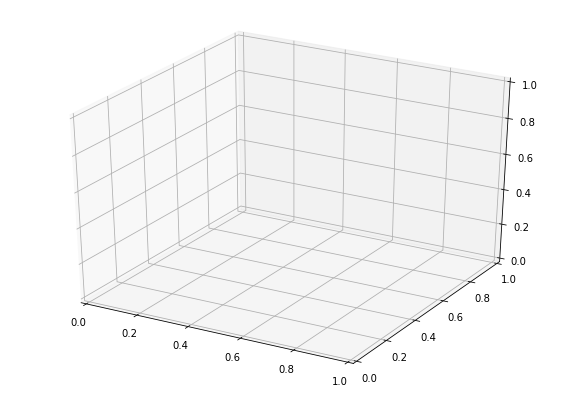

In [10]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize =(10, 7))
ax = fig.add_subplot(111, projection='3d')

x = mean_target_part1
y = mean_target_part4
z = mean_target_part2
c = mean_target_part3

x1 = mean_standard_part1
y1 = mean_standard_part4
z1 = mean_standard_part2
c1 = mean_standard_part3

img2 = ax.scatter(x1, y1, z1, c=c1, s = 100, marker = "*", cmap=plt.winter())
cbar = fig.colorbar(img2)
cbar.set_label('Pendiente de la ventana 1')

ax.set_xlabel('Pendiente de la ventana 3')
ax.set_ylabel('Pendiente de la ventana 4')
ax.set_zlabel('Pendiente de la ventana 2')
ax.set_label('Pendiente de la ventana 1')
plt.title('Pendientes en diferentes ventanas, los + P300 y los * son No P300')


img = ax.scatter(x, y, z, c=c, s = 100,marker = "+", cmap=plt.winter())
ax.view_init(40, 10)
#fig.colorbar(img,img2)
fig.savefig('scatter_Competition')
plt.show()

In [11]:
featuresT = np.concatenate((mean_target_part1, mean_target_part2, mean_target_part3, mean_target_part4), axis=1)
featuresF = np.concatenate((mean_standard_part1, mean_standard_part2, mean_standard_part3, mean_standard_part4), axis=1)
print(featuresT.shape)
print(featuresF.shape)

(10026, 4)
(50128, 4)


In [12]:
labelT = np.ones([len(mean_target_part1)])
labelF = np.zeros([len(mean_standard_part1)])
print(labelT.shape)
print(labelF.shape)

(10026,)
(50128,)


In [13]:
features = np.concatenate((featuresT,featuresF), axis=0)
labels = np.concatenate((labelT,labelF), axis=0)

print(features.shape)
print(labels.shape)

(60154, 4)
(60154,)


## División del dataset

In [14]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, accuracy_score
from sklearn.model_selection import cross_val_score, cross_validate


In [15]:

# Crear los datos de las características (X) y las etiquetas de las clases (y)
# Estos son datos de prueba, debes reemplazarlos por tus datos reales
X = features # Arreglo con los valores de las cuatro características
y = labels # Arreglo con las etiquetas de las clases (0 o 1)

# Dividir los datos en train y test usando una proporción de 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir el subconjunto de train en train y validation usando una proporción de 75/25
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Mostrar el resultado
print(X_train.shape) # (2052, 4)
print(X_val.shape) # (684, 4)
print(X_test.shape) # (684, 4)

(36092, 4)
(12031, 4)
(12031, 4)


## Entrenamiento

In [16]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, make_scorer

# Estos son datos de prueba, debes reemplazarlos por tus datos reales
X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

# Crear el clasificador de discriminante lineal
lda = LinearDiscriminantAnalysis()

# Crear un diccionario que mapee los nombres de las métricas con las funciones
scoring = ['f1', 'recall', 'precision', 'accuracy']
scores1 = cross_validate(lda, X, y, cv=20, scoring=scoring)


print('F1 SCORE:', scores1['test_f1'].mean())
print('Recall:', scores1['test_recall'].mean())
print('Precision:', scores1['test_precision'].mean())
print('Accuracy:', scores1['test_accuracy'].mean())
#print(scores1)

F1 SCORE: 0.09108107286431416
Recall: 0.048409188955996545
Precision: 0.8766840668567012
Accuracy: 0.8382469397030914


In [17]:
from sklearn import tree

X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

# Crea una instancia de la clase SVC
tr = tree.DecisionTreeClassifier(max_depth=7)

# Realiza validación cruzada en los datos
scoring = ['f1', 'recall', 'precision', 'accuracy']
scores2 = cross_validate(tr, X, y, cv=20, scoring=scoring)

print('F1 SCORE:', scores2['test_f1'].mean())
print('Recall:', scores2['test_recall'].mean())
print('Precision:', scores2['test_precision'].mean())
print('Accuracy:', scores2['test_accuracy'].mean())
#print(scores2)

F1 SCORE: 1.0
Recall: 1.0
Precision: 1.0
Accuracy: 1.0


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

# Crea una instancia del clasificador Random Forest
rfc = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)

# Realiza validación cruzada en los datos
scoring = ['f1', 'recall', 'precision', 'accuracy']
scores3 = cross_validate(rfc, X, y, cv=20, scoring=scoring)

print('F1 SCORE:', scores3['test_f1'].mean())
print('Recall:', scores3['test_recall'].mean())
print('Precision:', scores3['test_precision'].mean())
print('Accuracy:', scores3['test_accuracy'].mean())
#print(scores3)

F1 SCORE: 1.0
Recall: 1.0
Precision: 1.0
Accuracy: 1.0


In [19]:
from sklearn.svm import SVC

X = X_train # Arreglo con los valores de las cuatro características
y = y_train # Arreglo con las etiquetas de las clases (0 o 1)

# Crea una instancia de la clase SVC
svm = SVC(gamma="auto",kernel='rbf', C=1)

# Realiza validación cruzada en los datos
scoring = ['f1', 'recall', 'precision', 'accuracy']
scores4 = cross_validate(svm, X, y, cv=20, scoring=scoring)

print('F1 SCORE:', scores4['test_f1'].mean())
print('Recall:', scores4['test_recall'].mean())
print('Precision:', scores4['test_precision'].mean())
print('Accuracy:', scores4['test_accuracy'].mean())
#print(scores4)

F1 SCORE: 0.998189972130821
Recall: 0.9967186151855048
Precision: 0.99967159188956
Accuracy: 0.9993904588756288


## Test

In [20]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score
def evaluacion (y_test, y_predi):
  cm = confusion_matrix(y_test, y_predi, normalize='true')
  acc = accuracy_score(y_true=y_test , y_pred= y_predi)
  pre = precision_score(y_true=y_test , y_pred= y_predi)
  rec = recall_score(y_true=y_test , y_pred= y_predi)
  f1 = f1_score(y_true=y_test , y_pred= y_predi)
  k = cohen_kappa_score(y1=y_test, y2=y_predi)

  return {'Conf_Matrix':[cm],'Accuracy':acc,'Precision':pre,'Recall':rec,'F1_Score':f1,'Cohen_Kappa':k}

def comparar_modelos(y_test,y_predi,modelos):
  for i in range(len(y_test)):
    eval = evaluacion(y_test[i],y_predi[i])
    if(i==0):
      df = pd.DataFrame(eval, index=[0])
    else:
      df = df.append(eval, ignore_index=True)
  df['modelo'] = modelos
  df = df.reindex(columns=['modelo', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'Cohen_Kappa','Conf_Matrix'])
  fig = df.plot(kind = 'bar', x='modelo')
  #hist_modelos(df)
  return df, fig

4 4


,modelo,Accuracy,Precision,Recall,F1_Score,Cohen_Kappa,Conf_Matrix
0,LDA,0.839082,0.87037,0.046627,0.088512,0.072711,"[[0.9986020968547179, 0.001397903145282077], [..."
1,Tree,1.000000,1.00000,1.000000,1.000000,1.000000,"[[[1.0, 0.0], [0.0, 1.0]]]"
2,RF,1.000000,1.00000,1.000000,1.000000,1.000000,"[[[1.0, 0.0], [0.0, 1.0]]]"
3,SVM,0.839082,0.87037,0.046627,0.088512,0.072711,"[[[0.9986020968547179, 0.001397903145282077], ..."


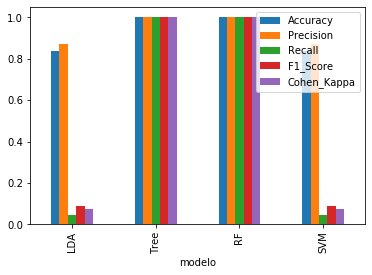

In [21]:
lda.fit(X, y)
tr = tr.fit(X_train, y_train)
rfc.fit(X, y)
svm.fit(X, y)

y_pred_lda = lda.predict(X_test)
y_pred_tr = tr.predict(X_test)
y_pred_rfc = rfc.predict(X_test)
y_pred_svm = lda.predict(X_test)
Y_test = [y_test, y_test, y_test, y_test]
y_predi = [y_pred_lda, y_pred_tr, y_pred_rfc, y_pred_svm]
print(len(Y_test), len(y_predi))
modelos = ['LDA','Tree','RF','SVM']
df, fig = comparar_modelos(Y_test,y_predi,modelos)
df

In [22]:
#from sklearn.metrics import clasification_report
#print(clasification_report(y_test, y_pred_rfc))

https://www.fisterra.com/formacion/metodologia-investigacion/medidas-concordancia-indice-kappa/

In [23]:
#importances = rfc.feature_importances_
#print(importances)
#columns = ['M ventana 1', 'M ventana 2', 'M ventana 3', 'M ventana 4']
#print(columns)
#sns.barplot(x=columns, y=importances, palette='bright', saturation=2.0, edgecolor='black', linewidth=2)
#plt.title('Importancia de cada Feature')
#plt.show()

In [24]:
#import graphviz
#dot_data = tree.export_graphviz(tr, out_file=None)
#graph = graphviz.Source(dot_data)
#graph.render("iris")


#dot_data = tree.export_graphviz(tr, out_file=None,
#                         feature_names=columns,
#                         class_names='P300',
#                         filled=True, rounded=True,
#                         special_characters=True)
#graph = graphviz.Source(dot_data)
#graph

In [25]:
import pandas as pd
def tup2data(scores1, clasificador):
  data_tuples = list(zip(scores1.keys(), scores1.values()))
  df1 = pd.DataFrame(data=data_tuples, columns=['metric', 'values'])
  df1 = df1.explode('values')
  df1['classifier'] = clasificador
  return df1

In [26]:
df1 = tup2data(scores1,'LDA')
df2 = tup2data(scores2,'Tree')
df3 = tup2data(scores3,'RF')
df4 = tup2data(scores4,'SVM')

In [27]:
df = pd.concat([df1, df2, df3, df4], axis = 0)
df

,metric,values,classifier
0,fit_time,0.0131447,LDA
0,fit_time,0.019263,LDA
0,fit_time,0.0192616,LDA
0,fit_time,0.0193574,LDA
0,fit_time,0.0212839,LDA
...,...,...,...
5,test_accuracy,0.999446,SVM
5,test_accuracy,0.998891,SVM
5,test_accuracy,0.999446,SVM
5,test_accuracy,0.998891,SVM


In [28]:
metrics_to_select = ['test_f1', 'test_recall', 'test_precision', 'test_accuracy']
df_selected = df.loc[df['metric'].isin(metrics_to_select)]
df_selected

,metric,values,classifier
2,test_f1,0.0509554,LDA
2,test_f1,0.0566038,LDA
2,test_f1,0.0384615,LDA
2,test_f1,0.155224,LDA
2,test_f1,0.056962,LDA
...,...,...,...
5,test_accuracy,0.999446,SVM
5,test_accuracy,0.998891,SVM
5,test_accuracy,0.999446,SVM
5,test_accuracy,0.998891,SVM


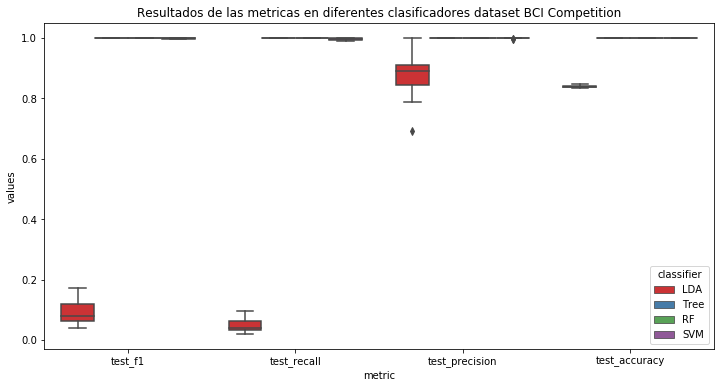

In [29]:
# DATOS DE ENTRADA
variable_numerica = "values"
variable_categorica_agrupacion = "metric"
variable_categorica_agrupacion2 = "classifier"
titulo_grafico = "Resultados de las metricas en diferentes clasificadores dataset BCI Competition"

#Gráfico Boxplot a una sola variable númerica según dos categorica
plt.figure(figsize=(12,6))
sns.boxplot(x=variable_categorica_agrupacion, y=variable_numerica, hue=variable_categorica_agrupacion2, data=df_selected, palette="Set1")
plt.title(titulo_grafico)
plt.savefig('boxplot_Competition')
plt.show()

## Clasificación con redes convolucionales
Se utiliza Keras para realizar la clasificación

In [30]:
np.squeeze(epochs["P300"][1].get_data()).shape

(16, 513)

In [31]:
len(epochs["NoP300"])

50128

In [32]:
target = epochs["P300"]
standard = epochs["NoP300"]
labelT = np.ones([len(epochs["P300"])])
labelF = np.zeros([len(epochs["NoP300"])])
features = np.concatenate((target,standard), axis=0)
labels = np.concatenate((labelT,labelF), axis=0)
labels = labels.reshape(-1,1)
labels.shape, features.shape

((60154, 1), (60154, 16, 513))

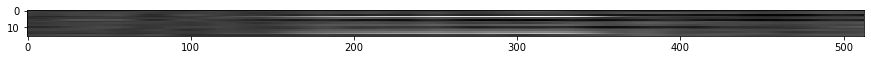

In [33]:
plt.figure(1, figsize=(15, 7))
plt.imshow(np.squeeze(epochs["P300"][6].get_data()), cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

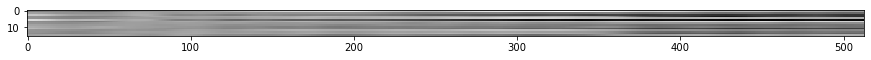

In [34]:
plt.figure(1, figsize=(15, 7))
plt.imshow(np.squeeze(epochs["NoP300"][6].get_data()), cmap=plt.cm.gray_r, interpolation='nearest')

plt.show()

In [38]:
from sklearn.model_selection import train_test_split
X = features # Arreglo con los valores de las cuatro características
y = labels # Arreglo con las etiquetas de las clases (0 o 1)

# Dividir los datos en train y test usando una proporción de 80/20
X_train, x_test, Y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dividir los datos en train y validation usando una proporción de 80/20
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [39]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from keras.metrics import Accuracy, AUC, Precision, Recall

# Crear modelo
model = Sequential()

# Agregar capas
model.add(Conv2D(64, kernel_size=2, activation='relu', input_shape=(64,241,1)))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Conv2D(32, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(3, activation='softmax'))
model.add(Dense(1, activation='softmax'))

# Compilar modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Accuracy(), AUC(), Precision(), Recall()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 63, 240, 64)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 21, 80, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 79, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 26, 32)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 4992)              0         
                                                                 
 dense (Dense)               (None, 3)                 1

In [40]:
#history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
69/69 [==============================] - 92s 1s/step - loss: 0.4723 - accuracy: 4.5704e-04 - auc: 0.5000 - precision: 0.1559 - recall: 1.0000 - val_loss: 0.4601 - val_accuracy: 0.0000e+00 - val_auc: 0.5000 - val_precision: 0.1642 - val_recall: 1.0000
Epoch 2/10
69/69 [==============================] - 77s 1s/step - loss: 0.4470 - accuracy: 0.0000e+00 - auc: 0.5000 - precision: 0.1559 - recall: 1.0000 - val_loss: 0.4549 - val_accuracy: 0.0000e+00 - val_auc: 0.5000 - val_precision: 0.1642 - val_recall: 1.0000
Epoch 3/10
69/69 [==============================] - 48s 696ms/step - loss: 0.4420 - accuracy: 0.0000e+00 - auc: 0.5000 - precision: 0.1559 - recall: 1.0000 - val_loss: 0.4514 - val_accuracy: 0.0000e+00 - val_auc: 0.5000 - val_precision: 0.1642 - val_recall: 1.0000
Epoch 4/10
69/69 [==============================] - 43s 624ms/step - loss: 0.4385 - accuracy: 0.0000e+00 - auc: 0.5000 - precision: 0.1559 - recall: 1.0000 - val_loss: 0.4494 - val_accuracy: 0.0000e+00 - val_auc

[0.4722656011581421, 0.4469696879386902, 0.44196170568466187, 0.4385404586791992, 0.43626314401626587, 0.43483009934425354, 0.4340008497238159, 0.4335370361804962, 0.43324536085128784, 0.4330577850341797]
[0.0004570384044200182, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004570384044200182, 0.0009140768088400364, 0.0004570384044200182]


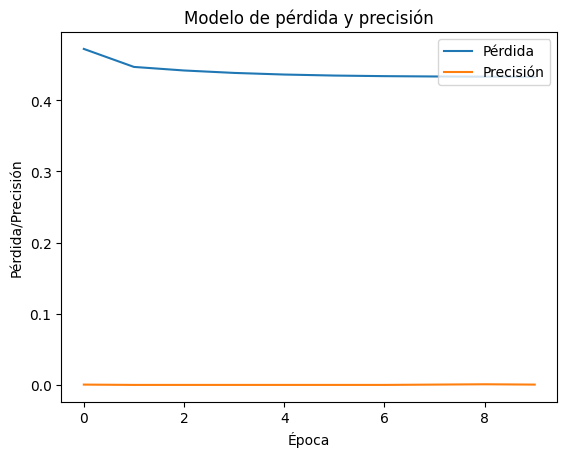

In [41]:
print(history.history['loss'])
print(history.history['accuracy'])

# Graficar pérdida y precisión
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('Modelo de pérdida y precisión')
plt.ylabel('Pérdida/Precisión')
plt.xlabel('Época')
plt.legend(['Pérdida', 'Precisión'], loc='upper right')
plt.show()